In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/cleaned_responses.csv")

print("Original dataset shape:", df.shape)
print("Target variable distribution:")
print(df['diabetes_diagnosed'].value_counts())
print(f"Diabetes prevalence: {(df['diabetes_diagnosed'].sum() / len(df)) * 100:.2f}%")


Original dataset shape: (314, 14)
Target variable distribution:
diabetes_diagnosed
0    211
1    103
Name: count, dtype: int64
Diabetes prevalence: 32.80%


In [2]:
# Feature selection and preparation

feature_cols = ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 
                'weight', 'height', 'insulin', 'bmi', 'physically_active', 
                'smoking', 'junk_food', 'family_history']

X = df[feature_cols].copy()
y = df['diabetes_diagnosed'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_cols}")

print("\nCorrelation with target variable:")
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)


Feature matrix shape: (314, 13)
Features used: ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 'weight', 'height', 'insulin', 'bmi', 'physically_active', 'smoking', 'junk_food', 'family_history']

Correlation with target variable:
blood_pressure       0.802786
age                  0.713982
glucose              0.568363
weight               0.559851
height               0.341301
family_history       0.334295
smoking              0.295420
pregnancies          0.272878
bmi                  0.230439
physically_active    0.110218
gender               0.078578
insulin              0.001255
junk_food           -0.052927
dtype: float64


In [3]:
# Data preparation and train-test split

complete_data = df[feature_cols + ['diabetes_diagnosed']].dropna()

X = complete_data[feature_cols].copy()
y = complete_data['diabetes_diagnosed'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"Training set diabetes prevalence: {(y_train.sum() / len(y_train)) * 100:.2f}%")

print(f"\nTest set target distribution:")
print(y_test.value_counts())
print(f"Test set diabetes prevalence: {(y_test.sum() / len(y_test)) * 100:.2f}%")

# Feature scaling for SVM
print("\nScaling features for SVM")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling completed.")



Training set target distribution:
diabetes_diagnosed
0    169
1     82
Name: count, dtype: int64
Training set diabetes prevalence: 32.67%

Test set target distribution:
diabetes_diagnosed
0    42
1    21
Name: count, dtype: int64
Test set diabetes prevalence: 33.33%

Scaling features for SVM
Feature scaling completed.


In [4]:
# Support Vector Machine Model Training

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3]  
}

svm = SVC(random_state=42, probability=True)  

grid_search = GridSearchCV(
    svm, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
)

print("Fitting SVM models with different parameter combinations...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

print("\nTraining final SVM model with best parameters...")
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)
print("SVM model training completed!")


Fitting SVM models with different parameter combinations...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9462

Training final SVM model with best parameters...
SVM model training completed!


In [5]:
# Model Evaluation

y_pred = best_svm.predict(X_test_scaled)
y_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nSVM Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\nCross-validation scores:")
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



SVM Model Performance Metrics:
Accuracy: 0.9524
Precision: 0.9091
Recall: 0.9524
F1-Score: 0.9302
AUC-ROC: 0.9909

Confusion Matrix:
[[40  2]
 [ 1 20]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.91      0.95      0.93        21

    accuracy                           0.95        63
   macro avg       0.94      0.95      0.95        63
weighted avg       0.95      0.95      0.95        63


Cross-validation scores:
CV F1-Score: 0.9462 (+/- 0.0704)



Support Vector Information:
Support vectors for class 0 (No Diabetes): 26
Support vectors for class 1 (Diabetes): 27
Total support vectors: 53
Support vector ratio: 21.12% of training data


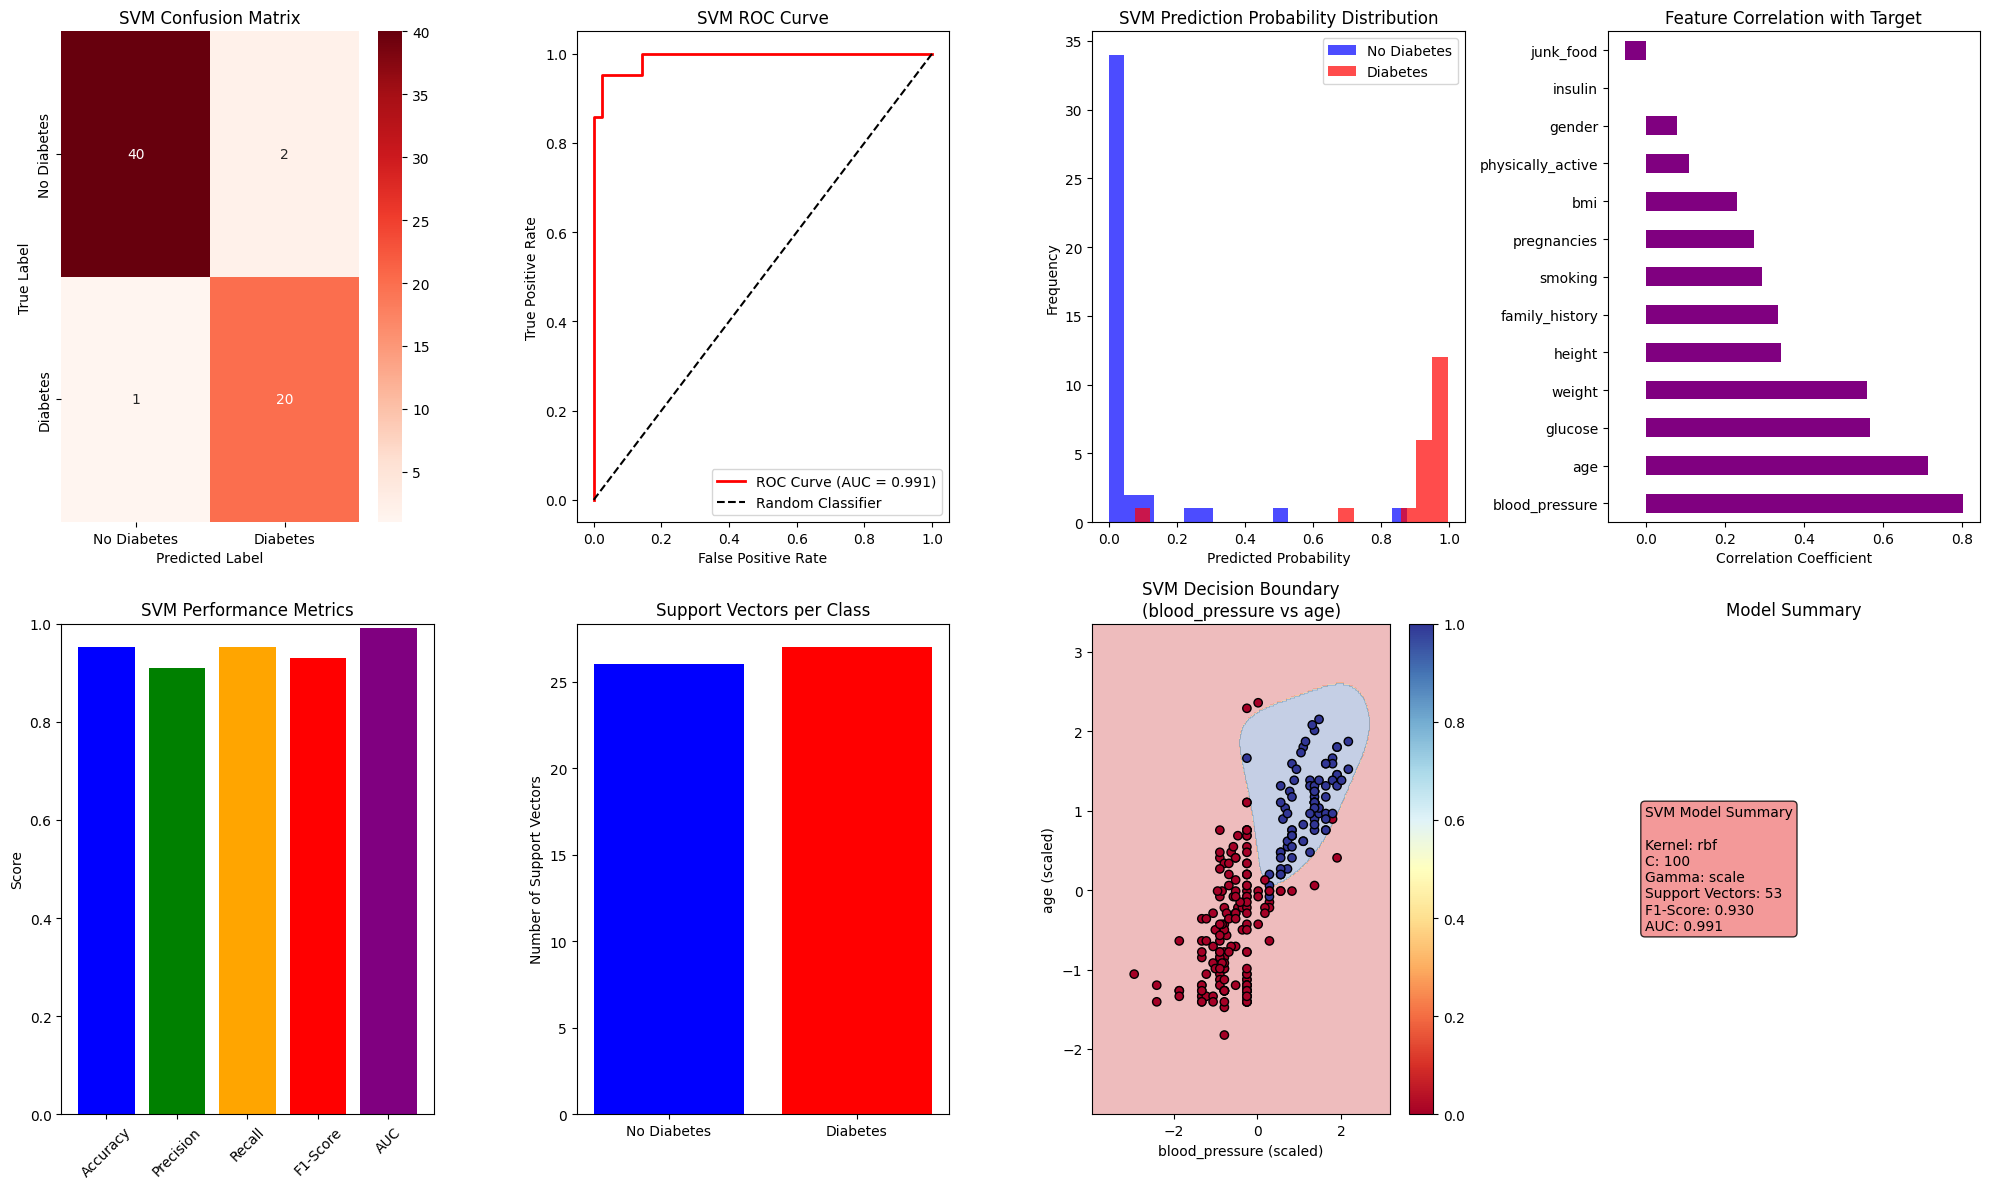

In [6]:
# Model Analysis and Visualizations

n_support_vectors = best_svm.n_support_
total_support_vectors = best_svm.n_support_.sum()

print(f"\nSupport Vector Information:")
print(f"Support vectors for class 0 (No Diabetes): {n_support_vectors[0]}")
print(f"Support vectors for class 1 (Diabetes): {n_support_vectors[1]}")
print(f"Total support vectors: {total_support_vectors}")
print(f"Support vector ratio: {total_support_vectors / len(X_train) * 100:.2f}% of training data")

plt.figure(figsize=(20, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 4, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 2. ROC Curve
plt.subplot(2, 4, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='red', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()

# 3. Prediction Probability Distribution
plt.subplot(2, 4, 3)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Diabetes', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Diabetes', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('SVM Prediction Probability Distribution')
plt.legend()

# 4. Feature Correlation with Target
plt.subplot(2, 4, 4)
correlations.plot(kind='barh', color='purple')
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation Coefficient')

# 5. Model Performance Summary
plt.subplot(2, 4, 5)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, auc]
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.bar(metrics, values, color=colors)
plt.title('SVM Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# 6. Support Vector Analysis
plt.subplot(2, 4, 6)
classes = ['No Diabetes', 'Diabetes']
support_counts = n_support_vectors
plt.bar(classes, support_counts, color=['blue', 'red'])
plt.title('Support Vectors per Class')
plt.ylabel('Number of Support Vectors')

# 7. Decision Boundary Visualization (2D projection)
plt.subplot(2, 4, 7)
top_features = correlations.head(2).index.tolist()
X_2d = X_train_scaled[:, [feature_cols.index(f) for f in top_features]]
X_test_2d = X_test_scaled[:, [feature_cols.index(f) for f in top_features]]

# Train a 2D SVM for visualization
svm_2d = SVC(kernel=best_svm.kernel, C=best_svm.C, gamma=best_svm.gamma, random_state=42)
svm_2d.fit(X_2d, y_train)

# Create a mesh for decision boundary
h = 0.02
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Make predictions on the mesh
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, cmap='RdYlBu', edgecolors='black')
plt.xlabel(f'{top_features[0]} (scaled)')
plt.ylabel(f'{top_features[1]} (scaled)')
plt.title(f'SVM Decision Boundary\n({top_features[0]} vs {top_features[1]})')
plt.colorbar(scatter)

# 8. Model Summary
plt.subplot(2, 4, 8)
summary_text = f'''SVM Model Summary

Kernel: {best_svm.kernel}
C: {best_svm.C}
Gamma: {best_svm.gamma}
Support Vectors: {total_support_vectors}
F1-Score: {f1:.3f}
AUC: {auc:.3f}'''
plt.text(0.1, 0.5, summary_text, ha='left', va='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
plt.axis('off')
plt.title('Model Summary')

plt.tight_layout()
plt.show()



In [7]:
# Model Interpretation and Comparison
print("SVM Model Interpretation:")
print("=" * 50)

print(f"\nSVM Model Summary:")
print(f"- Total features used: {len(feature_cols)}")
print(f"- Complete data samples: {len(complete_data)}")
print(f"- Training samples: {len(X_train)}")
print(f"- Test samples: {len(X_test)}")
print(f"- Data retention rate: {(len(complete_data) / df.shape[0]) * 100:.2f}%")
print(f"- Best hyperparameters: {grid_search.best_params_}")
print(f"- Cross-validation F1-score: {grid_search.best_score_:.4f}")
print(f"- Test F1-score: {f1:.4f}")
print(f"- Kernel type: {best_svm.kernel}")
print(f"- Regularization parameter (C): {best_svm.C}")
print(f"- Gamma parameter: {best_svm.gamma}")
print(f"- Total support vectors: {total_support_vectors}")
print(f"- Support vector ratio: {total_support_vectors / len(X_train) * 100:.2f}%")

# Save the trained model
model_path = "/Users/91life/Desktop/diabetes-project/models/"
os.makedirs(model_path, exist_ok=True)

joblib.dump(best_svm, f"{model_path}svm_model.pkl")
joblib.dump(scaler, f"{model_path}scaler_svm.pkl")

print(f"\nSVM model saved to: {model_path}")

print(f"Selected kernel: {best_svm.kernel}")


SVM Model Interpretation:

SVM Model Summary:
- Total features used: 13
- Complete data samples: 314
- Training samples: 251
- Test samples: 63
- Data retention rate: 100.00%
- Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
- Cross-validation F1-score: 0.9462
- Test F1-score: 0.9302
- Kernel type: rbf
- Regularization parameter (C): 100
- Gamma parameter: scale
- Total support vectors: 53
- Support vector ratio: 21.12%

SVM model saved to: /Users/91life/Desktop/diabetes-project/models/
Selected kernel: rbf
